In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import os

In [32]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='10GB')
client

C:\ProgramData\anaconda3\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 6948 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:6948/status,
Dashboard: http://127.0.0.1:6948/status,Workers: 2
Total threads: 4,Total memory: 18.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:6949,Workers: 2
Dashboard: http://127.0.0.1:6948/status,Total threads: 4
Started: Just now,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:6969,Total threads: 2
Dashboard: http://127.0.0.1:6970/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:6952,


# Read in data using Dask and Match up data

In [3]:
directory_path = 'trade_data/'

# Generate the file pattern for the years 1975 to 2000
file_pattern = directory_path + 'BACI_HS12_Y{year}_V202001.csv'

file_patterns = [file_pattern.format(year=year) for year in range(2016, 2019)]

df = dd.read_csv(file_patterns,assume_missing=True)

df

,t,i,j,k,v,q
npartitions=16,,,,,,
,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [5]:
import pandas as pd
products = pd.read_csv('trade_data/product_codes_HS12_V202001.csv',encoding='latin-1')
products = products.rename(columns={"code":"k"})

In [6]:
df_wdes = df.merge(products)
df_wdes.head()

,t,i,j,k,v,q,description
0,2016.0,4.0,12.0,80132.0,26.313,3.000,"Nuts, edible: cashew nuts, fresh or dried, she..."
1,2016.0,4.0,586.0,80132.0,1.095,1.105,"Nuts, edible: cashew nuts, fresh or dried, she..."
2,2016.0,8.0,703.0,80132.0,27.977,2.793,"Nuts, edible: cashew nuts, fresh or dried, she..."
3,2016.0,16.0,251.0,80132.0,18.203,1.400,"Nuts, edible: cashew nuts, fresh or dried, she..."
4,2016.0,31.0,784.0,80132.0,1.970,0.517,"Nuts, edible: cashew nuts, fresh or dried, she..."


In [7]:
countries = pd.read_csv('trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"i","iso_3digit_alpha":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv('trade_data/country_codes_V202001.csv',encoding='latin-1')
countries = countries.rename(columns={"country_code":"j","iso_3digit_alpha":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

In [8]:
df_wdes.head()

,t,i,j,k,v,q,description,name_i,name_j
0,2016.0,4.0,12.0,80132.0,26.313,3.000,"Nuts, edible: cashew nuts, fresh or dried, she...",AFG,DZA
1,2016.0,4.0,12.0,130190.0,1.507,0.585,"Natural gums, resins, gum-resins and oleoresin...",AFG,DZA
2,2016.0,4.0,12.0,370239.0,1.121,0.003,"Photographic film: in rolls, (other than with ...",AFG,DZA
3,2016.0,4.0,12.0,970600.0,17.236,0.019,Antiques: of an age exceeding one hundred years,AFG,DZA
4,2016.0,8.0,12.0,611020.0,1.226,0.035,"Jerseys, pullovers, cardigans, waistcoats and ...",ALB,DZA


# Describe the trade volume of the whole dataset in terms of value

In [9]:
trade_value_stats = df['v'].describe().compute()

# Print the descriptive statistics
print(trade_value_stats)

count    2.402566e+07
mean     2.090479e+03
std      6.687752e+04
min      1.000000e+00
25%      6.489589e+00
50%      3.579723e+01
75%      2.724135e+02
max      6.189576e+07
Name: v, dtype: float64


# List the five highest value sectors in the entire sample period

In [10]:
# Group by the product name and sum the trade values
sector_trade_values = df_wdes.groupby('description')['v'].sum()

# Compute the result to get the top five sectors with the highest trade values
top_five_sectors = sector_trade_values.nlargest(5).compute()

# Display the results
print("Top Five Sectors by Trade Value:")
print(top_five_sectors)

Top Five Sectors by Trade Value:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.552373e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    1.829220e+09
Vehicles: spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc                                                                                                       8.573921e+08
Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                                 

# Who were the top 10 countries with the most trading partners

In [11]:
# Group by 'exporter_name' and count unique 'importer_name' to find the number of unique trading partners
trading_partners = df_wdes.groupby('name_i')['name_j'].nunique()

# Compute the result to get the top 10 countries with the most unique trading partners
top_10_countries = trading_partners.nlargest(10).compute()

# Display the results
print("Top 10 Countries with the Most Trading Partners:")
print(top_10_countries)

Top 10 Countries with the Most Trading Partners:
name_i
DEU    219
NLD    219
BRA    218
FRA    218
ITA    218
GBR    218
THA    217
ESP    216
CHE    216
SWE    215
Name: name_j, dtype: int64


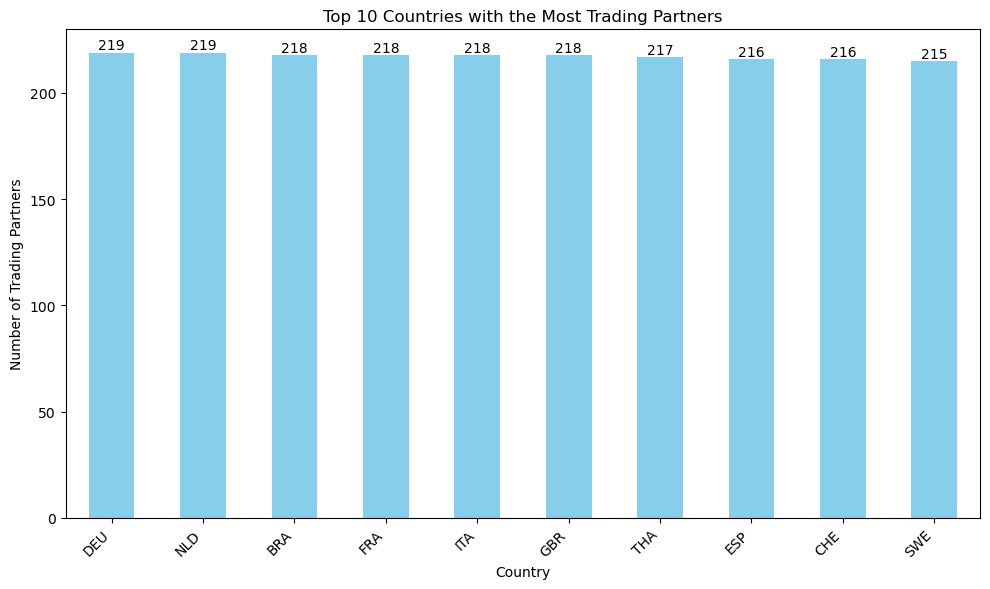

In [12]:
import matplotlib.pyplot as plt

# 创建图形和子图对象
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱形图
top_10_countries.plot(kind='bar', color='skyblue', ax=ax)

# 添加每个柱形上的合作伙伴数量文本标签
for i, v in enumerate(top_10_countries):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# 设置标题和标签
ax.set_title('Top 10 Countries with the Most Trading Partners')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Trading Partners')
ax.set_xticklabels(top_10_countries.index, rotation=45, ha='right')  # 设置x轴标签

# 显示图形
plt.tight_layout()
plt.show()

# Who were the bottom 10 countries with the fewest trading partners

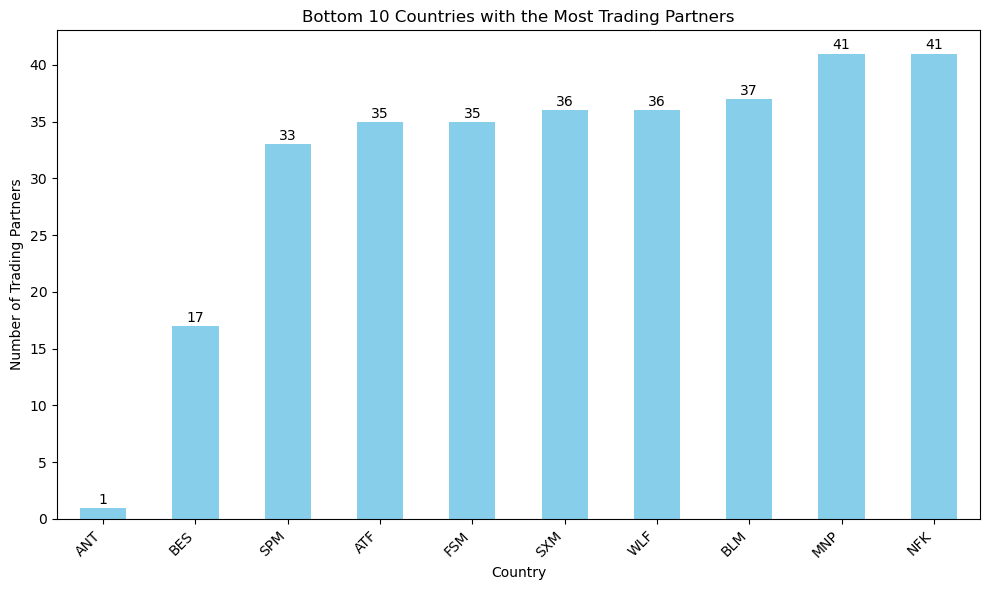

In [13]:
bottom_10_countries = trading_partners.nsmallest(10).compute()

# 创建图形和子图对象
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱形图
bottom_10_countries.plot(kind='bar', color='skyblue', ax=ax)

# 添加每个柱形上的合作伙伴数量文本标签
for i, v in enumerate(bottom_10_countries):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# 设置标题和标签
ax.set_title('Bottom 10 Countries with the Most Trading Partners')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Trading Partners')
ax.set_xticklabels(bottom_10_countries.index, rotation=45, ha='right')  # 设置x轴标签

# 显示图形
plt.tight_layout()
plt.show()

# Calculate the top 10 exports (in terms of value) of USA, EU in total, China, and Vietnam over the sample period (5 points)

In [17]:
# Dictionary of countries and their respective codes
countries = {
    'USA': 'USA',  # assuming 'USA' is the code used in your dataset
    'EU': ['GBR', 'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 
           'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'MLT', 'NLD', 
           'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE'],  # EU country codes
    'China': 'CHN',
    'Vietnam': 'VNM'
}

# Create a list of all relevant exporter codes, including handling the single code and list of codes correctly
all_codes = [countries['USA'], countries['China'], countries['Vietnam']] + countries['EU']

# Filter data for USA, EU, China, and Vietnam using 'exporter_code'
filtered_data = df_wdes[df_wdes['name_i'].isin(all_codes)]

# Aggregate trade values by exporter and product
top_exports = filtered_data.groupby(['name_i', 'description'])['v'].sum()

# Compute the result to get top exports for each country or region
top_exports = top_exports.compute().sort_values(ascending=False).groupby('name_i').head(10)

# Since the data includes EU countries separately, we need to aggregate EU data
eu_exports = top_exports.loc[countries['EU']].groupby('description').sum()
eu_top_10_exports = eu_exports.nlargest(10)

# Display the results for each entity by checking and indexing properly
print("Top 10 Exports for USA:")
print(top_exports.loc[[countries['USA']]])
print("\nTop 10 Exports for China:")
print(top_exports.loc[[countries['China']]])
print("\nTop 10 Exports for Vietnam:")
print(top_exports.loc[[countries['Vietnam']]])
print("\nTop 10 Exports for EU:")
print(eu_top_10_exports)

Top 10 Exports for USA:
name_i  description                                                                                                                                                                                                                             
USA     Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    2.308764e+08
        Aeroplanes and other aircraft: of an unladen weight exceeding 15,000kg                                                                                                                                                                      1.604832e+08
        Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                                      

# Calculate the top 10 goods with the highest trade volume for both exports and imports in terms of value and quantity

In [18]:
# Group by 'product_name' and sum the trade value 'v'
aggregated_trade_value = df_wdes.groupby('description')['v'].sum()

# Compute the result to get the top 10 goods with the highest trade value
top_10_goods_by_value = aggregated_trade_value.nlargest(10).compute()

# Display the results
print("Top 10 Goods by Total Trade Value:")
print(top_10_goods_by_value)

Top 10 Goods by Total Trade Value:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.552373e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    1.829220e+09
Vehicles: spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc                                                                                                       8.573921e+08
Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                               

In [19]:
aggregated_trade_quantity = df_wdes.groupby('description')['q'].sum()
top_10_goods_by_quantity = aggregated_trade_quantity.nlargest(10).compute()

# Display the results
print("Top 10 Goods by Total Trade Quantity:")
print(top_10_goods_by_quantity)

Top 10 Goods by Total Trade Quantity:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      6.735505e+09
Iron ores and concentrates: non-agglomerated                                                                                                                                                                                                4.143942e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    3.799377e+09
Coal: bituminous, whether or not pulverised, but not agglomerated                                                                                                                                          

In [20]:
aggregated_trade_value = df_wdes.groupby('description')['q'].sum()
top_goods_by_value = df_wdes.groupby('description')['v'].sum().nlargest(10).compute()

print("Top 10 goods by trade value:")
print(top_goods_by_value)

Top 10 goods by trade value:
description
Oils: petroleum oils and oils obtained from bituminous minerals, crude                                                                                                                                                                      2.552373e+09
Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils    1.829220e+09
Vehicles: spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc                                                                                                       8.573921e+08
Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale                                                                     

# Question 1.4
Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen
country and all the other centroids. You may use either haversine distance with the geographic
CRS or use a projected CRS and use the distance function of geopandas. (10 points).Please
also create a scatterplot of distance and export volume (quantity and value) in logarithm form (5
points)

In [22]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [ ]:
# Step 1: Load the shapefile
gdf = gpd.read_file('./countries_shapefile/cn_primary_countries.shp')

# Step 2: Calculate centroids
gdf['centroid'] = gdf.geometry.centroid

# Step 3: Find China's centroid
china_centroid = gdf[gdf['name'] == 'China']['centroid'].iloc[0]

In [ ]:
gdf.columns

In [ ]:
# Step 4: Calculate distances using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

gdf['distance_to_china'] = gdf['centroid'].apply(lambda x: haversine(china_centroid.x, china_centroid.y, x.x, x.y))

trade_data_agg = df_wdes.groupby('name_i').agg({'v': 'sum', 'q': 'sum'}).compute()

In [16]:
# Convert GeoDataFrame to DataFrame for merging
geo_df = pd.DataFrame(gdf.drop(columns='geometry'))
geo_df.columns

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'centroid', 'distance_to_china'],
      dtype='object')

In [24]:
geo_df = geo_df.rename(columns={"iso_a3":"name_i"})
geo_df = geo_df.rename(columns={"name_i":"iso_a3"})
geo_df.columns

Index(['ADM0_A3', 'abbrev', 'continent', 'formal_nam', 'iso_a2', 'iso_a3',
       'iso_n3', 'iso_short', 'name', 'name_sort', 'postal', 'primary',
       'short_name', 'sov_a3', 'sovereign', 'type', 'un_ar', 'un_en', 'un_es',
       'un_fr', 'un_n3', 'un_region', 'un_ru', 'un_subregi', 'un_zh', 'wb_a2',
       'wb_a3', 'wb_region', 'centroid', 'distance_to_china'],
      dtype='object')

In [25]:
# Merge geographic and trade data

merged_data = pd.merge(geo_df, trade_data_agg, left_on='iso_a3', right_on='name_i')

print(gdf[['iso_a3', 'distance_to_china']])

    iso_a3  distance_to_china
0      AFG        3427.944689
1      AGO       10489.123597
2      ALB        6985.295568
3      AND        8226.065852
4      ARE        4903.125626
..     ...                ...
188    WSM       10389.626066
189    YEM        5964.500594
190    ZAF       10970.788557
191    ZMB        9686.616650
192    ZWE        9901.954609

[193 rows x 2 columns]


In [26]:
import geopandas as gpd
import numpy as np

# If not already converted to a GeoDataFrame with lat and lon, you need to extract these from 'centroid' if possible
if 'longitude' not in merged_data.columns or 'latitude' not in merged_data.columns:
    merged_data['longitude'] = merged_data['centroid'].apply(lambda x: x.x)
    merged_data['latitude'] = merged_data['centroid'].apply(lambda x: x.y)

# Convert to GeoDataFrame if necessary
if not isinstance(merged_data, gpd.GeoDataFrame):
    merged_data = gpd.GeoDataFrame(merged_data, geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude))

C:\Users\huawei\AppData\Local\Temp\ipykernel_11772\2894521985.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


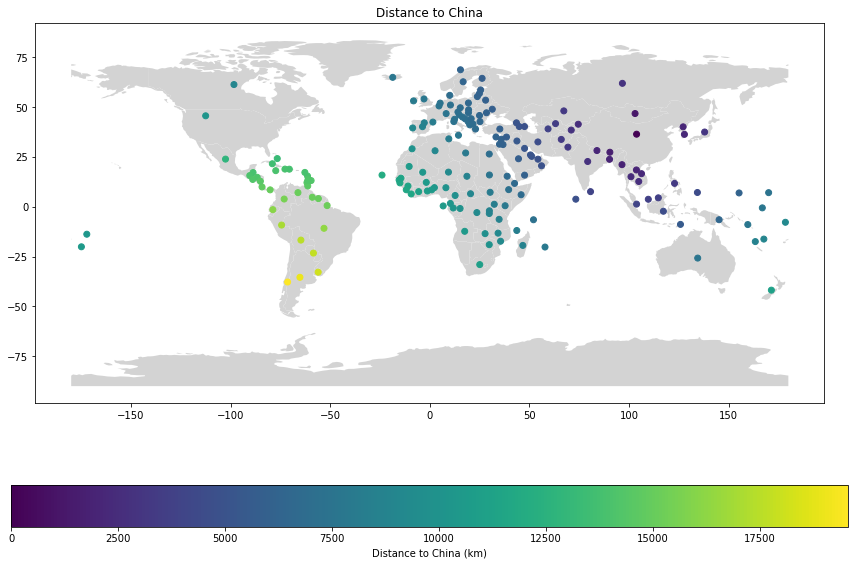

In [27]:
# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray')

# Plot distances using a color scale
merged_data.plot(ax=ax, column='distance_to_china', cmap='viridis', legend=True,
                 legend_kwds={'label': "Distance to China (km)", 'orientation': "horizontal"})

plt.title('Distance to China')
plt.show()

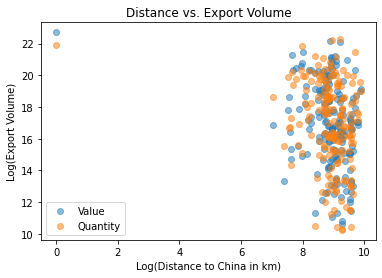

In [28]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(np.log1p(merged_data['distance_to_china']), np.log1p(merged_data['v']), label='Value', alpha=0.5)
ax.scatter(np.log1p(merged_data['distance_to_china']), np.log1p(merged_data['q']), label='Quantity', alpha=0.5)
ax.set_xlabel('Log(Distance to China in km)')
ax.set_ylabel('Log(Export Volume)')
ax.legend()
plt.title('Distance vs. Export Volume')
plt.show()

## Bonus Qs

Economic Intuition

For the question regarding which commodity sectors are most influenced by distance in terms of exporting, economic intuition suggests that several factors might be relevant:

Weight and Volume: Commodities that are bulkier or heavier (like raw materials and agricultural products) tend to have higher transportation costs, making distance a more critical factor.
Perishability: Perishable goods (such as fresh foods) may have limited export ranges due to the need for quicker delivery.
Value Density: High-value, low-volume goods (like electronics or pharmaceuticals) are less sensitive to distance because their transportation costs are a smaller proportion of their total value.
Market Dynamics: The necessity of goods in importing countries can also affect sensitivity to distance. Essential commodities might still be imported regardless of distance due to lack of local alternatives.
Data Requirements
To analyze how distance impacts the importance of exporting different commodity sectors, the following data would be needed:

Trade Data: Detailed records of trade flows between countries, including commodity sector, export quantities, and values.
Distance Data: Information on the distance between exporting and importing countries. This could be direct geographic distance or more complex measures that consider actual shipping routes or transportation infrastructure.
Commodity Characteristics: Data on the nature of the commodities being traded, including weight, volume, perishability, and value density.
Economic Indicators: GDP, population, and possibly economic openness of the trading countries, as these can influence trade volumes and patterns.

Data Manipulation

Merge and Clean Data: Combine trade, distance, and commodity characteristic data into a single dataset. Handle missing values and ensure consistent units across different sources.
Categorize Commodities: Group commodities into sectors based on their characteristics (e.g., perishable goods, heavy goods, high-value goods).
Compute Trade Weights: Create weighted measures of trade flows that consider both the quantity and the value of goods traded.

Analysis Strategy

Correlation Analysis: Calculate correlations between distance and trade volume/value for each commodity sector. This provides a preliminary view of which sectors are most impacted by distance.

Regression Analysis:

Perform econometric regressions where trade volume or value is the dependent variable, and distance, along with other economic indicators and commodity characteristics, are independent variables. Include interaction terms between distance and commodity characteristics to see if the impact of distance varies by these features.
Consider fixed effects for countries to control for unobserved heterogeneity.

Cluster Analysis:

Use clustering techniques to identify groups of commodity sectors based on their patterns of sensitivity to distance.

Visualization:

Plot scatter graphs of trade volume/value against distance for different commodity sectors.
Use heat maps to show the intensity of trade relationships over distances across different sectors.

# 2. Unsupervised Learning: Identifying Trade Patterns (40 pointsin total)

## 1. Normalize the trade data (e.g., using min-max scaling or standardization) to ensure comparability across different sectors and countries (10 points).

2.无监督学习：识别贸易模式（总分40分）
- 对贸易数据进行标准化（例如，使用最小-最大缩放或标准化），以确保在不同部门和国家之间具有可比性（10分）。
- 应用无监督学习技术，如K均值聚类或层次聚类，以识别基于其贸易模式（例如，出口/进口价值、部门、距离）的不同国家群体（10分）。
- 使用主成分分析（PCA）或t-SNE等技术可视化结果，以降低数据的维度并创建信息丰富的图表（10分）。
- 分析每个集群的特征，并讨论对理解国家间贸易动态和模式的潜在见解或影响（10分）。

1

In [28]:
from sklearn.preprocessing import MinMaxScaler
import dask.dataframe as dd

# 标准化
def scale_partition(partition):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(partition[['v', 'q']])
    return pd.DataFrame(scaled_values, columns=['v_norm', 'q_norm'], index=partition.index)

df_wdes_scaled = df_wdes.map_partitions(scale_partition, meta={'v_norm': 'float64', 'q_norm': 'float64'})
df_wdes = df_wdes.assign(v_norm=df_wdes_scaled['v_norm'], q_norm=df_wdes_scaled['q_norm'])

df_wdes.compute().head()


,t,i,j,k,v,q,description,name_i,name_j,v_norm,q_norm
0,2016.0,4.0,12.0,80132.0,26.313,3.000,"Nuts, edible: cashew nuts, fresh or dried, she...",AFG,DZA,6.723748e-07,4.353264e-09
1,2016.0,4.0,12.0,130190.0,1.507,0.585,"Natural gums, resins, gum-resins and oleoresin...",AFG,DZA,1.346715e-08,8.488853e-10
2,2016.0,4.0,12.0,370239.0,1.121,0.003,"Photographic film: in rolls, (other than with ...",AFG,DZA,3.214054e-09,4.351751e-12
3,2016.0,4.0,12.0,970600.0,17.236,0.019,Antiques: of an age exceeding one hundred years,AFG,DZA,4.312676e-07,2.756917e-11
4,2016.0,8.0,12.0,611020.0,1.226,0.035,"Jerseys, pullovers, cardigans, waistcoats and ...",ALB,DZA,6.003109e-09,5.078659e-11


2 应用无监督学习技术

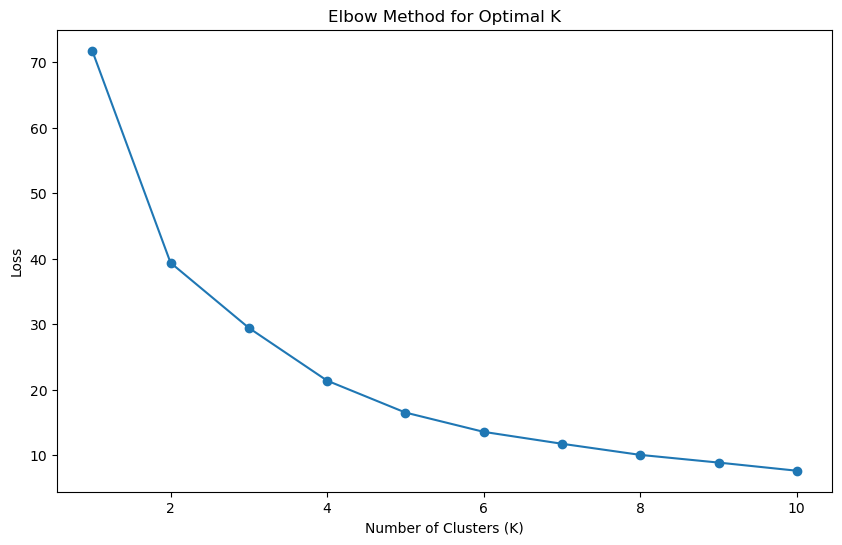

In [35]:
from sklearn.cluster import KMeans
import numpy as np

# 特征列
features = ['v_norm', 'q_norm'] 

# 转换为数组
X = df_wdes[df_wdes['t'] == 2016][features].compute().values  

# 存储每个 K 值对应的损失函数值
losses = []

# 不同的 K 值，训练 K-means
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    losses.append(kmeans.inertia_)

# 可视化肘部法图
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), losses, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Loss')
plt.title('Elbow Method for Optimal K')
plt.show()


0    7891772
2        672
1         64
Name: cluster, dtype: int64


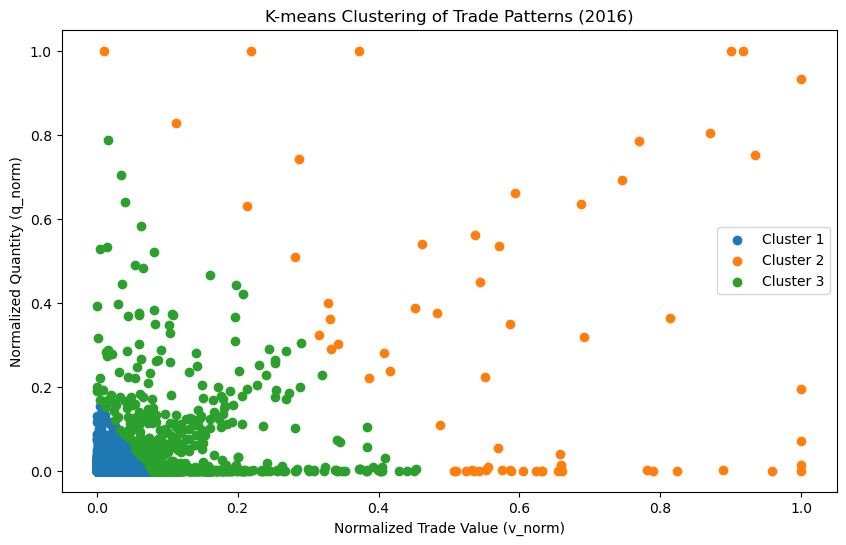

In [36]:
# 选择特征列
features = ['v_norm', 'q_norm'] 

# 提取特征列转换数组
X = df_wdes[df_wdes['t'] == 2016][features].compute().values  

# K-means K = 3
kmeans = KMeans(n_clusters=3, random_state=42)  
kmeans.fit(X)

# 获取簇标签
cluster_labels = kmeans.labels_

df_wdes = df_wdes.compute() 
df_wdes_2016 = df_wdes[df_wdes['t'] == 2016].copy()  # 2016年的数据
df_wdes_2016['cluster'] = cluster_labels
df_wdes = dd.from_pandas(df_wdes, npartitions=1)  

# 每个簇的样本数量
cluster_counts = df_wdes_2016['cluster'].value_counts()
print(cluster_counts)

# 可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for cluster in range(3):  
    cluster_data = df_wdes_2016[df_wdes_2016['cluster'] == cluster]
    plt.scatter(cluster_data['v_norm'], cluster_data['q_norm'], label=f'Cluster {cluster+1}')

plt.xlabel('Normalized Trade Value (v_norm)')
plt.ylabel('Normalized Quantity (q_norm)')
plt.title('K-means Clustering of Trade Patterns (2016)')
plt.legend()
plt.show()



3.使用主成分分析（PCA）

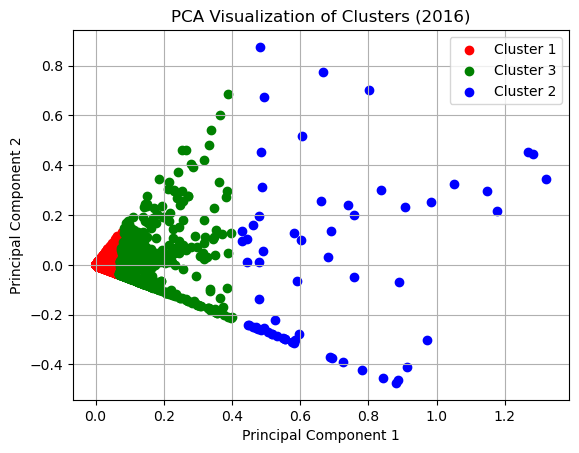

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = df_wdes[df_wdes['t'] == 2016][features].compute().values  

# PCA降维
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# 添加簇标签
pca_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])
df_wdes_2016_reset = df_wdes_2016.reset_index(drop=True)
pca_df['cluster'] = df_wdes_2016_reset['cluster']

# 绘制散点图
fig, ax = plt.subplots()
colors = ['r', 'g', 'b']
for cluster, color in zip(pca_df['cluster'].unique(), colors):
    ax.scatter(pca_df.loc[pca_df['cluster'] == cluster, 'principal component 1'], pca_df.loc[pca_df['cluster'] == cluster, 'principal component 2'], c=color, label=f'Cluster {cluster+1}')
ax.legend()
ax.grid(True)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters (2016)')
plt.show()


4.分析每个集群的特征